In [1]:
import numpy as np
from collections import OrderedDict
from scipy.spatial import distance as dist
from scipy.optimize import linear_sum_assignment
from typing import List, Optional

In [2]:
class CentroidTracker():
    def __init__(self, maxDisappeared=50):
        self.nextObjectID = 0
        self.objects = OrderedDict()
        self.disappeared = OrderedDict()
        self.maxDisappeared = maxDisappeared
        
    def register(self, centroid: List):
        """Register new object with its centroid"""
        self.objects[self.nextObjectID] = centroid
        self.disappeared[self.nextObjectID] = 0 # mark the number of frame the object is not there (right now is 0)
        self.nextObjectID += 1
        
    def deregister(self, objectID: int):
        """Deregister object if it disappeared from frame for more than max threshold"""
        del self.objects[objectID]
        del self.disappeared[objectID]
    
    def update(self, rects: List[List]):
        """update object list if there are new object appeared
        Arg:
            rects: List of list, elements is bounding box rectangles (feed in by the object detector)
                   example: [(startX, startY, endX, endY), ...]
        """
        # check if the list of bounding box is empty
        if len(rects) == 0:
            # loop through the list of all existing object and mark them as disappeared
            # by adding 1 (number of frame it is disappearing)
            for objectID in list(self.disappeared.keys()):
                self.disappeared[objectID] += 1
            
                # if the number of frame disappear exceed the max threshold, deregister the object:
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)
            # If there's no object tracked before, return blank object list
            return self.objects
        
        # get list of centroid from the input bounding boxes:
        inputCentroids = list()
        
        for (startX, startY, endX, endY) in rects:
            cX = int((startX + endX)/ 2.0)
            cY = int((startY + endY)/ 2.0)
            inputCentroids.append((cX, cY))
        
        # if there's no object tracked before, simply register all new object with its centroid
        if len(self.objects) == 0:
            for obj in inputCentroids:
                self.register(obj)
                
        # else need to figure which one is already in the list to track.
        else:
            objectIDs = list(self.objects.keys())
            objectCentroids = list(self.objects.values())
            
            dist_matrix = dist.cdist(np.array(objectCentroids), inputCentroids)
            
            row_ind, col_ind = linear_sum_assignment(dist_matrix)
            
            usedRows = set()
            usedCols = set()
            
            for (row, col) in zip(row_ind, col_ind):
                if row in usedRows or col in usedCols:
                    continue
                
                objectID = objectIDs[row]
                self.objects[objectID] = inputCentroids[col]
                self.disappeared[objectID] = 0
                
                usedRows.add(row)
                usedCols.add(col)
                
            unusedCols = set(range(dist_matrix.shape[1])).difference(usedCols)
            unusedRows = set(range(dist_matrix.shape[0])).difference(usedRows)
            
            # Set case when there are more new objects than current tracked objects
            if dist_matrix.shape[0] < dist_matrix.shape[1]:
                for col in unusedCols: 
                    self.register(inputCentroids[col])
                    
            # In case there are more tracked objects than new objects:
            else:
                # Then increase the disappeared frame by 1
                for row in unusedRows:
                    objectID = objectIDs[row]
                    self.disappeared[objectID] += 1
                    
                # Then check if the number of disappeared frame exceed the threshold:
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)
              
        # return the set of tracked objects:
        return self.objects

In [3]:
Track_A = CentroidTracker()
Track_A.objects

OrderedDict()

In [4]:
Track_A.update([[0,0,0,0], [2,2,2,2], [1,1,1,1]])

OrderedDict([(0, (0, 0)), (1, (2, 2)), (2, (1, 1))])

In [5]:
Track_A.objects

OrderedDict([(0, (0, 0)), (1, (2, 2)), (2, (1, 1))])

In [6]:
Track_A.update([[0,1,0,1], [2,3,2,3], [1,2,1,2], [4,4,4,4]])

OrderedDict([(0, (0, 1)), (1, (2, 3)), (2, (1, 2)), (3, (4, 4))])

In [7]:
Track_A.objects

OrderedDict([(0, (0, 1)), (1, (2, 3)), (2, (1, 2)), (3, (4, 4))])

In [8]:
from imutils.video import VideoStream
import argparse
import imutils
import time
import cv2

In [9]:
parser = argparse.ArgumentParser() 
parser.add_argument("-p", "--prototxt", required=True, type=str, help="path to Caffe deploy prototxt file")
parser.add_argument("-m", "--model", required=True, type=str, help="path to Caffe pre-trained model")
parser.add_argument("-c", "--confidence", type=float, default=0.5, help="minimum probability to filter weak detections")

args = vars(parser.parse_args())
blue = (255,165,0)
centroid_tracker = CentroidTracker()
(Height, Width) = (None, None)
net = cv2.dnn.readNetFromCaffe(args["prototxt"], args["model"])
# net = cv2.dnn.readNetFromCaffe("simple-object-tracking/deploy.prototxt", "simple-object-tracking/res10_300x300_ssd_iter_140000.caffemodel")

video_stream = VideoStream(src=0).start()
time.sleep(2.0)

cv2.startWindowThread()

# loop through every frame of the video stream
while True:
    frame = video_stream.read()
    frame = imutils.resize(frame, width=400)
    
    if Height is None or Width is None:
        # get the first two dimensions of the frame
        (Height, Width) = frame.shape[:2]
    
    # construct blob from the frame
    blob = cv2.dnn.blobFromImage(frame, scalefactor=1.0, size=(Width, Height), mean=(104.0, 177.0, 123.0))
    # default for swapping Red and Blue channel (swapRB) is false
    
    # pass the blob through the model and get the predictions 
    net.setInput(blob)
    detections = net.forward()
    rects = list() #bounding box list
    
    # loop over detection
    for i in range(detections.shape[2]):
        # select only prediction with probability larger than a threshold
        if detections[0, 0, i, 2] > 0.5: #args["confidence"]:
            # get all the bounding box coordinates 
            box = detections[0, 0, i, 3:7] * np.array([Width, Height, Width, Height])
            rects.append(box.astype("int"))
            
            # draw bounding boxes based on their coordinates:
            (startX, startY, endX, endY) = box.astype("int")
            cv2.rectangle(frame, (startX, startY), (endX, endY), 
                          color=blue, thickness=2)
        
    # with the list of bounding boxes, update centroid tracker
    objects = centroid_tracker.update(rects)
    
    # display ID number with all objects detected and tracked:
    for (objectID, centroid) in objects.items():
        text_display = "ID {}".format(objectID)
        cv2.putText(frame, text=text_display, org=(centroid[0]-10, centroid[1]-10), 
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, 
                    color=blue, thickness=3)
        cv2.circle(frame, centroid, radius=5, color=blue, thickness=-1)
        
    cv2.imshow("Face tracking", frame)
    
    # set up an exit key, display the frame until a designated key is pressed
    key = cv2.waitKey(1) & 0xFF 
    
    # The 0xFF is added to ensure that even when NumLock is activated, key pressed will have the same result
    # For more explanation, look here: https://stackoverflow.com/questions/35372700/whats-0xff-for-in-cv2-waitkey1
    
    # break the loop after 1s when q(quit) is pressed
    if key == ord('q'):
#         cv2.waitKey(1)
#         video_stream.stop()
#         cv2.waitKey(1)
#         cv2.destroyAllWindows()
#         cv2.waitKey(1)
        break
        
# Cleanup
cv2.waitKey(1)
cv2.destroyAllWindows() # Doesn't work here but works fine when running from terminal.
cv2.waitKey(1)
cv2.waitKey(1)
cv2.waitKey(1)
cv2.waitKey(1)
video_stream.stop()

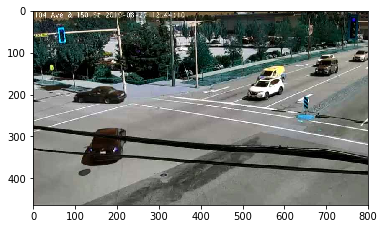

In [1]:
from matplotlib import pyplot as plt

%matplotlib inline

img = cv2.imread("data/enc_104_150_cam1.jpg")
img2 = img[:,:,::-1]
plt.imshow(img);


In [2]:
net = cv2.dnn.readNetFromCaffe("simple-object-tracking/deploy.prototxt", "simple-object-tracking/res10_300x300_ssd_iter_140000.caffemodel")
(Height, Width) = img.shape[:2]
    
# construct blob from the frame
blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(Width, Height), mean=(104.0, 177.0, 123.0))
# default for swapping Red and Blue channel (swapRB) is false

# pass the blob through the model and get the predictions 
net.setInput(blob)
detections = net.forward()
rects = list() #bounding box list


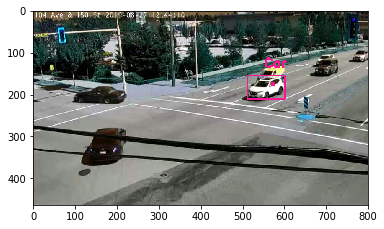

In [4]:
# loop over detection
for i in range(detections.shape[2]):
    # select only prediction with probability larger than a threshold
#     if detections[0, 0, i, 2] > 0.5:
    # get all the bounding box coordinates 
    box = detections[0, 0, i, 3:7] * np.array([Width, Height, Width, Height])
    rects.append(box.astype("int"))

    # draw bounding boxes based on their coordinates:
    (startX, startY, endX, endY) = box.astype("int")
    image = cv2.rectangle(img, (startX-40, startY), (endX+10, endY+10), (255,20,147), 2)
    image = cv2.putText(img, "Car", (startX, startY-20), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, 
                  color=(255,20,147), thickness=3)  
    image = cv2.circle(img, center=(startX+20, startY+20), radius=5, color=(255,20,147), thickness=-1)
  
    plt.imshow(image)

    break